<a href="https://colab.research.google.com/github/schumbar/CMPE258/blob/chumbar%2Fassignment_03/assignment_03/CMPE258_assignment03_part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 03 Part A - FastAI

## Assignment Description

Perform the following tasks:
Use FastAI to write a detailed Colab notebook that shows training and inference for the following tasks using FastAI. Showcase results and metrics:

- Vision object detection task
- Vision segmentation task
- Tabular task
- Recommendation task

## References Used
1. [FastAI Introduction Colab](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb)
2. ChatGPT was used for general purpose debugging.

### Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install fastai
!pip install ucimlrepo

In [3]:
from fastai.vision.all import *
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision import *
from fastai.collab import *
from io import BytesIO
import pandas as pd
import requests
import os

### Vision Segmentation Task


#### Dataset Preprocessing and Model Training

In [4]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 193MB/s]


epoch,train_loss,valid_loss,time
0,3.102385,2.452658,00:03


epoch,train_loss,valid_loss,time
0,1.804006,1.471168,00:01
1,1.568313,1.367414,00:01
2,1.394227,1.111175,00:01
3,1.247944,0.918211,00:01
4,1.116142,0.798378,00:01
5,1.007442,0.793907,00:01
6,0.921987,0.777009,00:01
7,0.853818,0.758061,00:01


#### Model Evaluation

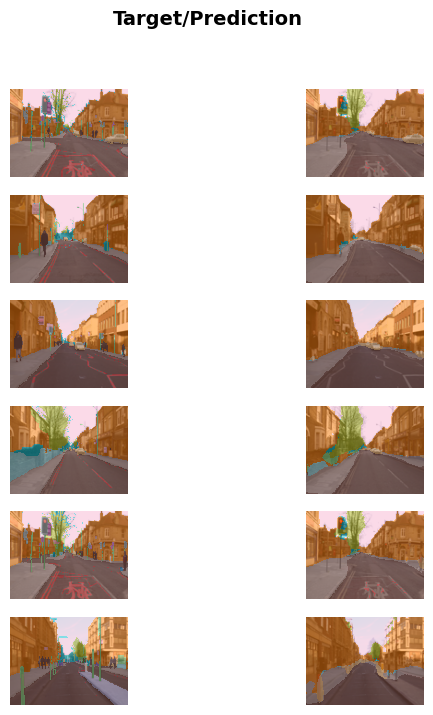

In [5]:
learn.show_results(max_n=6, figsize=(7,8))

### Vision Object Detection Task

In [6]:
def save_image(image_url, save_path):
  response = requests.get(image_url)
  image = Image.open(BytesIO(response.content))
  image.save(save_path)


#### Defining Model

In [8]:
path = untar_data(URLs.PETS)/'images'

In [9]:
def is_cat(x): return x[0].isupper()

In [10]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

#### Model Training

In [11]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

#### Model Fine-tuning

In [12]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.167701,0.027556,0.008796,00:24


epoch,train_loss,valid_loss,error_rate,time
0,0.051660,0.021129,0.007442,00:31


#### Model Evaluation

In [13]:
image_url = "https://raw.githubusercontent.com/schumbar/CMPE258/main/assignment_03/data/cat.jpeg"
cat_image_file_path = "/content/sample_data/cat.jpeg"
save_image(image_url, cat_image_file_path)

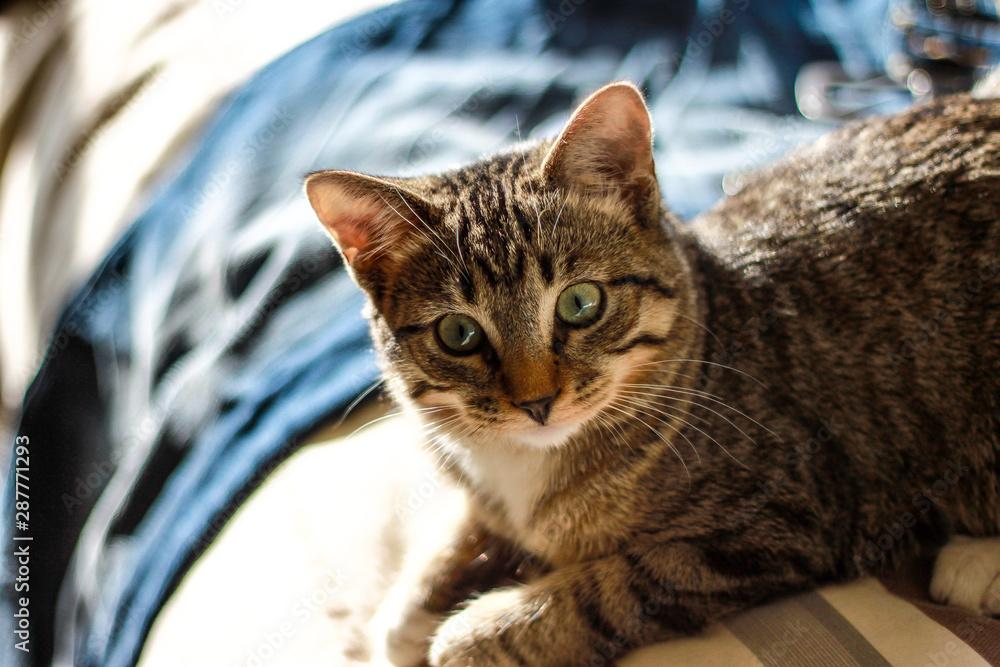

In [14]:
cat_img = PILImage.create(cat_image_file_path)
cat_img

In [15]:
is_cat,_,probs = learn.predict(cat_img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


In [16]:
image_url = "https://raw.githubusercontent.com/schumbar/CMPE258/main/assignment_03/data/dog.jpeg"
dog_image_file_path = "/content/sample_data/dog.jpeg"
save_image(image_url, dog_image_file_path)

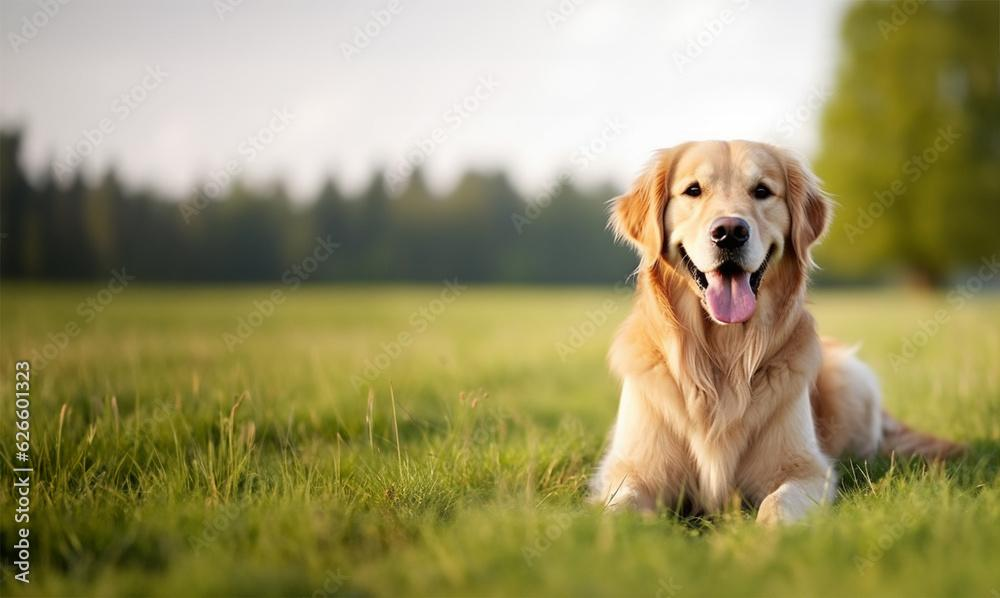

In [17]:
dog_img = PILImage.create(dog_image_file_path)
dog_img

In [18]:
is_cat,_,probs = learn.predict(dog_img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000015


### Tabular Task

#### Dataset

In [19]:
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')


In [20]:
procs = [Categorify, FillMissing, Normalize]


In [21]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs, ['workclass', 'education', 'marital-status', 'occupation',
                                'relationship', 'race'],
                   cont_names=['age', 'fnlwgt', 'education-num'],
                   y_names="salary", splits=splits)
dls = to.dataloaders(bs=64)


#### Defining Model

In [22]:
learn = tabular_learner(dls, metrics=accuracy)


#### Model Training

In [23]:
learn.fit_one_cycle(3)


epoch,train_loss,valid_loss,accuracy,time
0,0.390605,0.367004,0.829545,00:05
1,0.357789,0.353943,0.836302,00:04
2,0.347816,0.352865,0.833385,00:04


#### Model Evaluation

In [24]:
learn.show_results()


,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary,salary_pred
0,5.0,16.0,1.0,9.0,2.0,5.0,1.0,1.279581,2.318653,-0.031974,0.0,0.0
1,5.0,16.0,5.0,2.0,2.0,5.0,1.0,0.324458,0.040268,-0.031974,0.0,0.0
2,5.0,10.0,3.0,14.0,6.0,5.0,1.0,-0.851077,1.327611,1.142230,1.0,1.0
3,5.0,12.0,3.0,5.0,1.0,5.0,1.0,-0.851077,-0.831478,-0.423376,0.0,0.0
4,8.0,15.0,3.0,5.0,1.0,5.0,1.0,0.544871,0.578250,1.925032,1.0,1.0
5,5.0,16.0,3.0,13.0,1.0,5.0,1.0,0.691813,0.434871,-0.031974,1.0,1.0
6,5.0,12.0,3.0,15.0,1.0,5.0,1.0,-0.630665,0.358386,-0.423376,0.0,0.0
7,5.0,10.0,3.0,2.0,6.0,5.0,1.0,0.765284,-0.273749,1.142230,1.0,1.0
8,5.0,12.0,5.0,4.0,2.0,5.0,1.0,-0.483723,0.348787,-0.423376,0.0,0.0


In [25]:
row, clas, probs = learn.predict(df.iloc[0])

In [26]:
output = f"row = {row} \nclass = {clas} \nprobs = {probs}"
print(output)

row =    workclass  education  marital-status  occupation  relationship  race  \
0        5.0        8.0             3.0         0.0           6.0   5.0   

   education-num_na       age    fnlwgt  education-num  salary  
0               1.0  0.765284 -0.834294       0.750828     1.0   
class = 1 
probs = tensor([0.4504, 0.5496])


### Recommendation Task

#### Load Dataset

In [27]:
path = untar_data(URLs.ML_100k)
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user', 'movie', 'rating'])
ratings.head()

,user,movie,rating
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596


In [28]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [29]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,242,3,881250949,Four Rooms (1995)
1,302,3,891717742,Four Rooms (1995)
2,451,3,886324817,Four Rooms (1995)
3,86,3,883603013,Four Rooms (1995)
4,40,3,891035994,Four Rooms (1995)


#### Create DataLoader

In [30]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

#### Define the Model

In [31]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))


#### Train the Model

In [32]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,780510319209349120.000000,780640473898287104.000000,00:08
1,780524956457893888.000000,780640473898287104.000000,00:08
2,780716889956417536.000000,780640473898287104.000000,00:08
3,780675726989852672.000000,780640473898287104.000000,00:08
4,780668580164272128.000000,780640473898287104.000000,00:08


#### Model Evaluation

In [33]:
learn.show_results()

,user,title,rating,rating_pred
0,173,1,878695241,5.5
1,237,1,880261056,5.5
2,68,3,892705239,5.5
3,298,3,885682528,5.5
4,421,3,875087352,5.5
5,550,3,886317599,5.5
6,483,1,891035112,5.5
7,584,2,879525035,5.5
8,279,3,884196640,5.5


In [34]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Get Shorty (1995)', 'Four Rooms (1995)', 'Copycat (1995)',
       'GoldenEye (1995)', 'Toy Story (1995)'], dtype=object)

In [35]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([5])

In [36]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [37]:
user_id = 1000
movies_to_predict_for = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# create a dataframe with pairs [user_id, movie_id]
df = pd.DataFrame({
    'user': [user_id] * len(movies_to_predict_for),
    'title': movies_to_predict_for
})

# covert it to DataLoader and make predictions
dl = learn.dls.test_dl(df)
preds = learn.get_preds(dl=dl)

# merge predictions with movie ids
preds_df = pd.DataFrame({
    'title': movies_to_predict_for,
    'prediction': preds[0].numpy().flatten()
}).sort_values('prediction', ascending=False)

# show top 10 ratings
display(preds_df[:10])

,title,prediction
0,1,2.987418
1,2,2.987418
2,3,2.987418
3,4,2.987418
4,5,2.987418
5,6,2.987418
6,7,2.987418
7,8,2.987418
8,9,2.987418
9,10,2.987418


In [38]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(0.9041), 'Copycat (1995)', 883597804.015471),
 (tensor(1.0448), 'GoldenEye (1995)', 883766374.1766051),
 (tensor(1.1146), 'Get Shorty (1995)', 883365234.9171007),
 (tensor(1.2767), 'Four Rooms (1995)', 883547384.7366735),
 (tensor(1.4398), 'Toy Story (1995)', 883680382.128969)]